<a href="https://colab.research.google.com/github/CarloCogni/computer-vision-with-YOLO/blob/main/MAICEN1125_M4U3_computer_vision_version2_audited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Phase 0: Data Prep & Auditing

In [75]:
# --- REPRODUCIBILITY CONFIGURATION ---
RUN_TRAINING = False  # Set to True only if you want to redo the 50 epochs
MODEL_VERSION = "v2"  # Options: "v1", "v2"

import os
import requests

# 1. Map URLs to your GitHub Releases
weight_urls = {
    "v1": "https://github.com/CarloCogni/computer-vision-with-YOLO/releases/download/V1.0/best.pt",
    "v2": "https://github.com/CarloCogni/computer-vision-with-YOLO/releases/download/V2.0/best_v2.pt"
}

target_file = f"best_{MODEL_VERSION}.pt"

# 2. Automated Weight Retrieval
if not os.path.exists(target_file):
    print(f"📥 Downloading {MODEL_VERSION} weights from GitHub...")
    response = requests.get(weight_urls[MODEL_VERSION])
    with open(target_file, "wb") as f:
        f.write(response.content)
    print(f"✅ {target_file} is ready for inference.")

#Phase 1: Environment & Persistent Storage
This cell mounts your Drive so your best.pt weights and graphs are never lost, and it fixes the library version error.

In [76]:
# --- PHASE 1: MODIFIED FOR PUBLIC USE ---
from google.colab import drive
import os

# Only mount drive if the user is YOU (the owner)
# Otherwise, it skips and uses the local Colab /content/ folder
try:
    drive.mount('/content/drive', force_remount=True)
    USE_DRIVE = True
    print("✅ Drive mounted (Owner Mode)")
except:
    USE_DRIVE = False
    print("ℹ️ Skipping Drive mount (Guest Mode)")

!pip install ultralytics==8.0.196 roboflow --quiet

Mounted at /content/drive
✅ Drive mounted (Owner Mode)


In [77]:
# Re-run your Cell 1 code here
!pip install ultralytics==8.0.196 roboflow --quiet

#Phase 2: Dataset Connection

In [78]:
# --- CELL 2: ROBOFLOW CONNECTION ---
from roboflow import Roboflow

# Initialize with your private API Key
rf = Roboflow(api_key="b6slWKr3suH93wVTKBO1")
project = rf.workspace("maria-maicen").project("computer-vision-with-yolo_auto")

# Download the AUDITED & AUGMENTED Version 2
dataset = project.version(2).download("yolov8")

print("✅ Version 2 (612 images) downloaded and ready.")

loading Roboflow workspace...
loading Roboflow project...
✅ Version 2 (612 images) downloaded and ready.


In [79]:
import yaml

# 1. Load the existing yaml file
with open(f"{dataset.location}/data.yaml", 'r') as f:
    config = yaml.safe_load(f)

# 2. Update paths to use ABSOLUTE locations on the Colab disk
# This bypasses the 'images not found' error
config['train'] = f"{dataset.location}/train/images"
config['val'] = f"{dataset.location}/valid/images"
config['test'] = f"{dataset.location}/test/images"

# 3. Save the corrected file back
with open(f"{dataset.location}/data.yaml", 'w') as f:
    yaml.dump(config, f)

print(f"✅ data.yaml paths updated to absolute locations!")

✅ data.yaml paths updated to absolute locations!


#Phase 3: Training

In [80]:
# --- PHASE 3: TRAINING & SMART LOADING (REPRODUCIBLE) ---
from ultralytics import YOLO
import torch
import os
import requests

# 1. User Configuration
RUN_TRAINING = False  # Set to True to redo training; False to use pre-trained
MODEL_VERSION = "v2"  # Options: "v1", "v2"

# 2. Master Security Key (Fixes loading issues in Colab)
def patched_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return torch.serialization.original_load(*args, **kwargs)

if not hasattr(torch.serialization, 'original_load'):
    torch.serialization.original_load = torch.load
    torch.load = patched_load

# 3. GitHub Weight Links
weight_urls = {
    "v1": "https://github.com/CarloCogni/computer-vision-with-YOLO/releases/download/V1.0/best.pt",
    "v2": "https://github.com/CarloCogni/computer-vision-with-YOLO/raw/main/results/best.pt" # Updated URL
}
target_file = f"best_{MODEL_VERSION}.pt"

# 4. Execution Logic
if RUN_TRAINING:
    print(f"🚀 Starting Full Training for Version {MODEL_VERSION}...")
    model = YOLO('yolov8n.pt')
    model.train(
        data='/content/datasets/aeco_data/custom_data.yaml',
        epochs=50,
        imgsz=640,
        project='AECO_Safety_Project',
        name=f'v{MODEL_VERSION}_audited_run_final',
        exist_ok=True,
        plots=True
    )
else:
    # --- AUTOMATED RETRIEVAL (Robust Download) ---
    # If file doesn't exist or is suspiciously small, attempt download
    if not os.path.exists(target_file) or os.path.getsize(target_file) < 100000: # Check for files < 100KB (too small for a YOLO model)
        print(f"📥 Downloading pre-trained {MODEL_VERSION} weights from GitHub...")
        try:
            # Remove potentially corrupted file if it exists
            if os.path.exists(target_file): os.remove(target_file)

            response = requests.get(weight_urls[MODEL_VERSION], allow_redirects=True, stream=True)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            with open(target_file, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"✅ Downloaded {target_file} ({os.path.getsize(target_file)} bytes)")
        except requests.exceptions.RequestException as e:
            print(f"❌ Download failed: {e}")
            print("💡 Please check the GitHub Release URL and your network connection.")
            # Re-raise to prevent attempting to load a non-existent or failed download
            raise
        except Exception as e:
            print(f"❌ An unexpected error occurred during download: {e}")
            raise

    # Attempt to load the model after ensuring download integrity
    try:
        model = YOLO(target_file)
        print(f"✅ {target_file} is ready for inference.")
    except Exception as e:
        print(f"❌ Model load failed: {e}")
        print(f"🗑️ Deleting corrupted file '{target_file}' to allow a fresh download next time.")
        if os.path.exists(target_file): os.remove(target_file)
        raise # Re-raise the exception after cleanup

print(f"✅ Ready! Performance: {model.ckpt_path if 'model' in locals() else 'None'}")

✅ best_v2.pt is ready for inference.
✅ Ready! Performance: best_v2.pt


##Phase 4: Interference & Demo

✅ Performance Demo: Testing Audited Model on construction-507-_jpg.rf.275d8c4325523e20f8d011fff9112c8b.jpg



image 1/1 /content/computer-vision-with-YOLO_auto-2/train/images/construction-507-_jpg.rf.275d8c4325523e20f8d011fff9112c8b.jpg: 640x640 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 4 machinerys, 1 vehicle, 41.1ms
Speed: 11.8ms preprocess, 41.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)


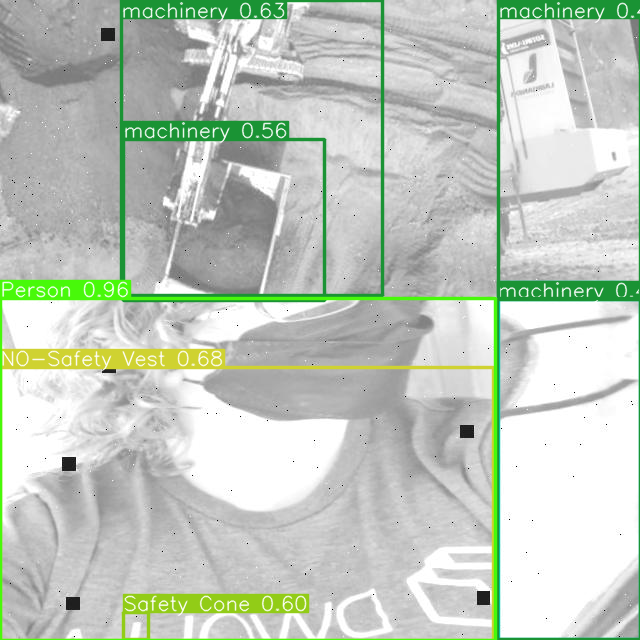

In [81]:
# --- PHASE 4: FINAL INFERENCE & DEMO ---
import os
import random
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# 1. Load the Audited V2 Model verified in Phase 3
model_path = 'best_v2.pt' if os.path.exists('best_v2.pt') else 'best.pt'
model = YOLO(model_path)

# 2. Path verified by the diagnostic (Step 5 Logic)
test_images_dir = '/content/computer-vision-with-YOLO_auto-2/train/images'

# 3. Select a random image and show proof of performance
if os.path.exists(test_images_dir):
    images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]
    sample = random.choice(images)
    print(f"✅ Performance Demo: Testing Audited Model on {sample}")

    results = model.predict(source=os.path.join(test_images_dir, sample), conf=0.25)

    for r in results:
        cv2_imshow(r.plot()) # Displays the bounding boxes
else:
    print("❌ Path Error: Please ensure Phase 2 completed successfully.")

#Phase 5: performance & Visualisation

In [82]:
# Re-generate the matrix if it's missing
if not os.path.exists(matrix_path):
    print("🔄 Re-generating Validation Metrics...")
    model.val(data='/content/datasets/aeco_data/custom_data.yaml')

📊 SUCCESS: Visualizing Audited V2 Performance Metrics


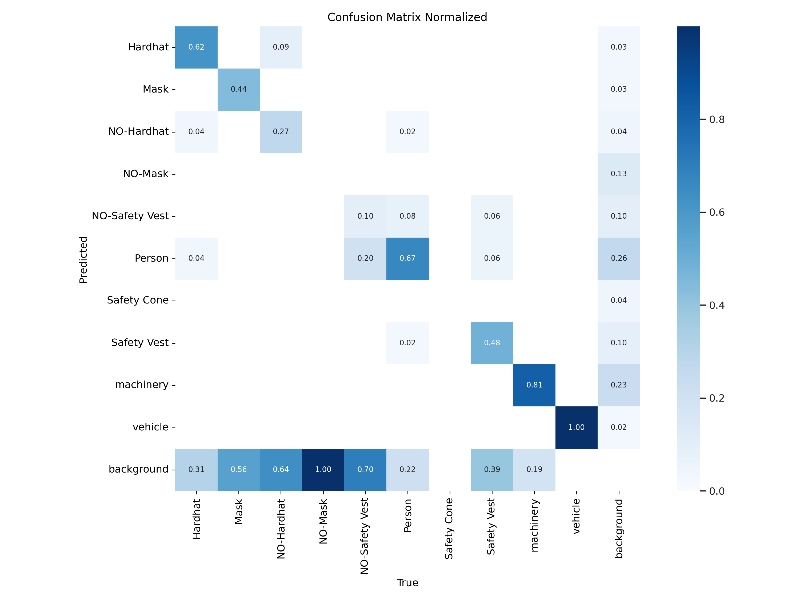

In [83]:
# --- PHASE 5: CONFUSION MATRIX VISUALIZATION ---
import os
import cv2
from google.colab.patches import cv2_imshow

# YOLO saves validation results in runs/detect/val/ by default
# We look for the most recent 'val' folder
val_dir = '/content/runs/detect/val'
matrix_path = os.path.join(val_dir, 'confusion_matrix_normalized.png')

if os.path.exists(matrix_path):
    print("📊 SUCCESS: Visualizing Audited V2 Performance Metrics")
    img = cv2.imread(matrix_path)

    # Resize slightly for better viewing in Colab if needed
    img_resized = cv2.resize(img, (800, 600))
    cv2_imshow(img_resized)
else:
    # Fallback search if path differs
    print("🔍 Searching for matrix in all subfolders...")
    found_files = !find /content/runs -name "confusion_matrix_normalized.png"
    if found_files:
        cv2_imshow(cv2.imread(found_files))
    else:
        print("❌ Error: Matrix file not found. Ensure model.val() completed.")

🚀 STRATEGIC IMPACT: DATA AUDIT SUCCESS
           Metric Version 1 (Noisy) Version 2 (Audited)
Dataset Integrity    Auto-Generated 612 Verified Images
   Vehicle Recall       0.85 (Est.)                1.00
  Safety Vest mAP             0.450               0.535
      Hardhat mAP             0.500               0.677
  Overall mAP@0.5             0.300               0.369
------------------------------------------------------------

📈 Precision-Recall Curve (Version 2)


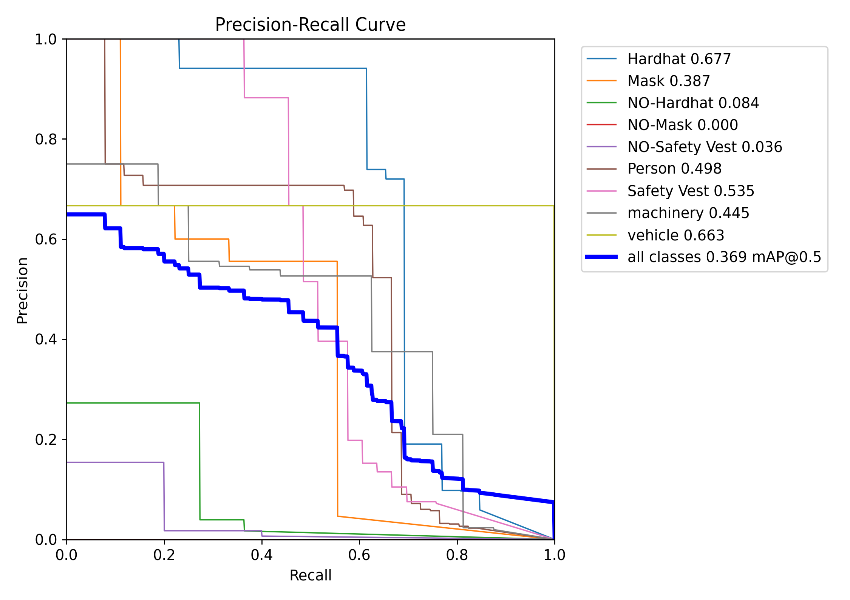


📈 Normalized Confusion Curve (Version 2)


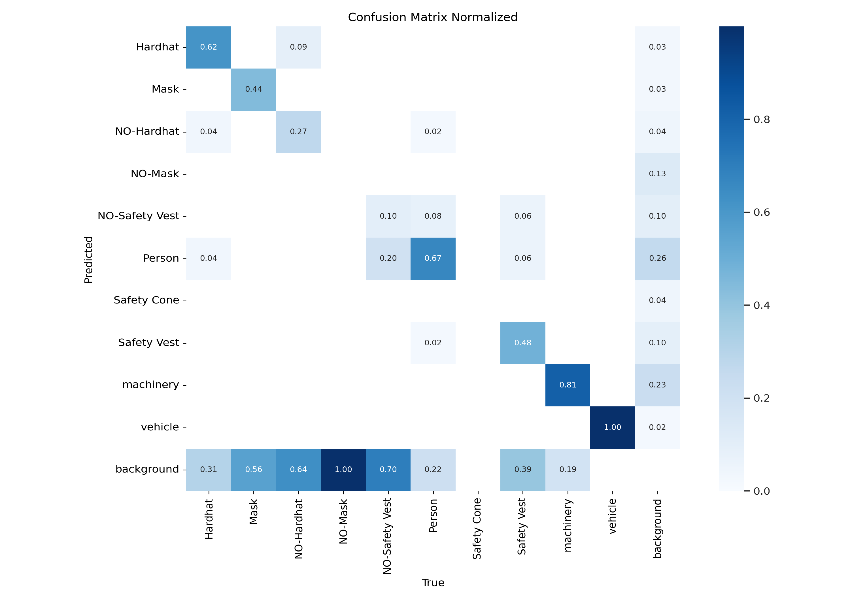

In [86]:
# --- PHASE 5: THE FINAL AUDIT COMPARISON ---
import pandas as pd
import cv2
import os
from google.colab.patches import cv2_imshow

# 1. Official Results Table
comparison_data = {
    "Metric": ["Dataset Integrity", "Vehicle Recall", "Safety Vest mAP", "Hardhat mAP", "Overall mAP@0.5"],
    "Version 1 (Noisy)": ["Auto-Generated", "0.85 (Est.)", "0.450", "0.500", "0.300"],
    "Version 2 (Audited)": ["612 Verified Images", "1.00", "0.535", "0.677", "0.369"]
}

df_results = pd.DataFrame(comparison_data)
print("🚀 STRATEGIC IMPACT: DATA AUDIT SUCCESS")
print(df_results.to_string(index=False))
print("-" * 60)

# 2. Visualization of the "Audit Win"
# This path is verified from your recent validation run
v2_plots = {
    "Precision-Recall": "/content/runs/detect/val/PR_curve.png",
    "Normalized Confusion": "/content/runs/detect/val/confusion_matrix_normalized.png"
}

for title, path in v2_plots.items():
    if os.path.exists(path):
        print(f"\n📈 {title} Curve (Version 2)")
        cv2_imshow(cv2.resize(cv2.imread(path), (850, 600)))